## Credit Card Fraud Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_auc_score
from sklearn.manifold import TSNE

#Packages for handling imbalanced datasets
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# importing classifier packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.plotting import plot_learning_curves

RANDOM_SEED = 42


### Importing Dataset

In [2]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df.isnull().values.

### Exploratory Data Analysis

In [3]:
df.isnull().values.any()

False

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

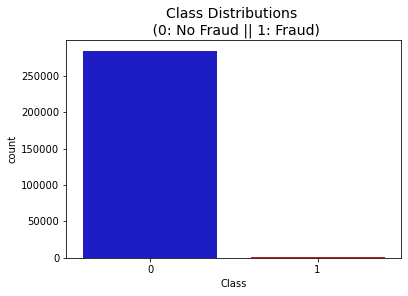

In [4]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

### Splitting Data into Train and Test sets

In [5]:
train_columns = df.columns.tolist()
train_columns = [c for c in train_columns if c not in ["Class"]]
target = "Class"

X = df[train_columns]
y = df[target]

In [6]:
sss = StratifiedKFold(n_splits=5,  shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [7]:
ytrain = ytrain.values.reshape(-1,1)
ytest = ytest.values.reshape(-1,1)

### Perform Feature scaling

In [8]:
column_indices = []
column_indices.append(Xtrain.columns.get_loc('Time'))
column_indices.append(Xtrain.columns.get_loc('Amount'))

In [9]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import RobustScaler 
column_trans = ColumnTransformer([('scaler', RobustScaler(), column_indices)], remainder='passthrough') 
column_trans.fit(Xtrain)
Xtrain = column_trans.transform(Xtrain)
Xtest = column_trans.transform(Xtest)

### Over Sampling to handle imbalanced dataset

In [10]:
from imblearn.over_sampling import RandomOverSampler
os =  RandomOverSampler(sampling_strategy='minority', random_state=42)
X_res, y_res = os.fit_sample(Xtrain, ytrain)

In [11]:
X_res.shape

(454904, 30)

In [12]:
# smt = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
# X_res, y_res = smt.fit_sample(Xtrain, ytrain)

In [13]:
df_sampled = pd.DataFrame(data = X_res, columns = train_columns)
df_sampled[target] = y_res

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

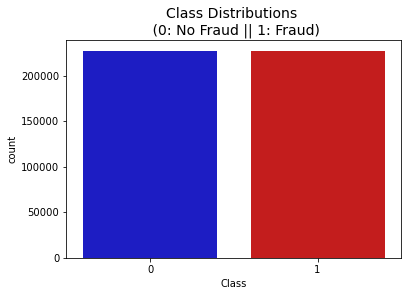

In [14]:
sns.countplot('Class', data=df_sampled, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [15]:
X_res.shape

(454904, 30)

In [16]:
Xtrain.shape

(227846, 30)

### Training Classifiers

##### Logistic Regression

In [17]:
max_iter = list(range(600,900,100))
C_values = [0.001, 0.01, 0.1, 1]
log_reg_params = [{'penalty': ['l1','l2'], 'solver': ['liblinear'], 'max_iter': max_iter, 'C': C_values}]
grid_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
grid_log_reg.fit(X_res, y_res)
log_reg = grid_log_reg.best_estimator_

### ROC Curve

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, Xtrain, ytrain.flatten(), cv=5,
                             method="decision_function")

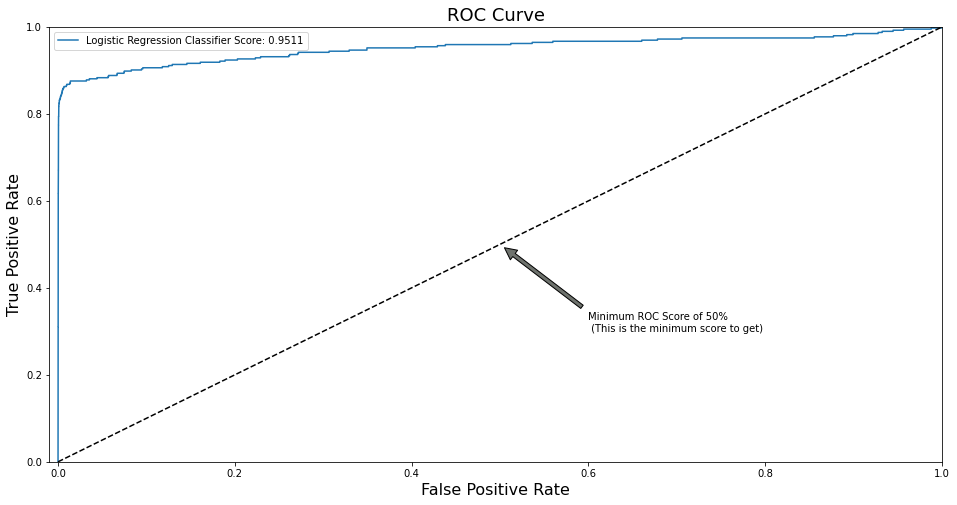

In [20]:
log_fpr, log_tpr, log_thresold = roc_curve(ytrain, log_reg_pred)
plt.figure(figsize=(16,8))
plt.title('ROC Curve', fontsize=18)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(ytrain, log_reg_pred)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
plt.legend()
plt.show()
    

### Cross Validation with SMOTE

In [21]:
type(Xtrain)

numpy.ndarray

In [23]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

max_iter = list(range(500,1100,100))
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

log_reg_params = [{'penalty': ['l1','l2'], 'solver': ['liblinear'], 'max_iter': max_iter, 'C': C_values},
              {'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': max_iter , 'C': C_values}]

# log_reg_params = {"penalty": ['l1', 'l2'],"solver": ['lbfgs', 'liblinear'], 'max_iter': list(range(100,600,100)) , 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, test in sss.split(Xtrain, ytrain): 
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), log_reg)
    model = pipeline.fit(Xtrain[train], ytrain[train])
#     best_est = rand_log_reg.best_estimator_
    prediction = model.predict(Xtrain[test])
    
    accuracy_lst.append(pipeline.score(Xtrain[test], ytrain[test]))
    precision_lst.append(precision_score(ytrain[test], prediction))
    recall_lst.append(recall_score(ytrain[test], prediction))
    f1_lst.append(f1_score(ytrain[test], prediction))
    auc_lst.append(roc_auc_score(ytrain[test], prediction))


In [30]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9556766086080613
precision: 0.059021745832250415
recall: 0.9137617656604998
f1: 0.10938463278765749
---------------------------------------------------------------------------------------------------------------------------------------


In [33]:
from sklearn.metrics import classification_report
labels = ['No Fraud', 'Fraud']
smote_prediction = log_reg.predict(Xtest)
print(classification_report(ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56863
       Fraud       0.07      0.86      0.13        98

    accuracy                           0.98     56961
   macro avg       0.53      0.92      0.56     56961
weighted avg       1.00      0.98      0.99     56961

